# _N_-gram Accuracy (Section 5.1)

This notebook investigates the general accuracy for supervised classification algorithms when they are applied to the TF-IDF transformed corpus. Multiple classifiers are compared to try to ensure that the demonstrated accuracy is a result of the feature universe and not simply that the data is suited to one style of algorithm. Most of the algorithms perform better when the TF-IDF vectors have been reduced to 50 dimensions using `TruncatedSVD` (a technique sometimes called LSA or Latent Semantic Analysis), but methods based on decision trees (`ExtraTrees` and `XGBoost` with the `gbtree` algorithm are tested here) seem to underperform slightly.

It was initially hypothesised that restricting the contextual corpus to longer poems would improve the classification accuracy; put another way there were concerns that the results on shorter poems would be too variable to be useful. This turned out to be mostly not the case, although there are problems distinguishing between Ovid's _Tristia_ and _Ex Ponto_ (which is to be expected, as discussed in the paper).

Overall, the results show that lexico-grammatical style (as measured here using 2-,3- and 4-grams with TF-IDF and SVD) is distinctive, and both works and authors separate well in this feature space.

In [1]:
import warnings
warnings.filterwarnings("ignore")

from mqdq import utils, babble, elegy, ngrams
from mqdq import line_analyzer as la
from mqdq import mahalanobis as maha

import bs4
import glob

import numpy as np
import pandas as pd
import scipy as sp

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, cross_validate
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from xgboost import XGBClassifier

In [2]:
%load_ext rpy2.ipython

# Load Corpus

These XML files have all been downloaded from the [Pedecerto](http://www.pedecerto.eu/public/pagine/autori) collection, which offers fully scanned works from the [MQDQ](https://mizar.unive.it/mqdq/public/) corpus. Once again I'd like to thank those teams for providing such a fantastic resource under a permissive license. Some files in my corpus directory have been altered by me to remove a few problematic unicode characters that interfered with my own software.

In [3]:
collection = []

# Several lines need to be manually deleted, because when we make wide vectors
# we treat couplets as a unit (so we must have a matching number of H and P.)
# In some poems, we have corrupt lines, and so we delete the H that matches
# a corrupt P and vice versa.

ep = babble.bookbabs('corpus/OV-epis.xml', name="Ep.")
for b in ep:
    b.author = 'Ovid'
collection.extend(ep)

tr = babble.multi_bookbabs(sorted(glob.glob('corpus/OV-tri*.xml')), name="Tr.")
for b in tr:
    b.author = 'Ovid'
collection.extend(tr)

am = babble.multi_bookbabs(sorted(glob.glob('corpus/OV-amo*.xml')), name="Am.")
for b in am:
    b.author = 'Ovid'
collection.extend(am)

tib = babble.multi_bookbabs(sorted(glob.glob('corpus/TIB-ele*.xml')), name="Tib.")
del tib[1].raw_source[24]
for b in tib:
    b.author = 'Tibullus'
collection.extend(tib)

prop = babble.multi_bookbabs(sorted(glob.glob('corpus/PROP-ele*.xml')), name="Prop.")
for b in prop:
    b.author = 'Propertius'
del prop[55].raw_source[28]
collection.extend(prop)

cat = babble.bookbabs('corpus/CATVLL-carm.xml', name="Cat.")
cat_ele = [x for x in cat if x.elegiac and len(x) > 20]
for b in cat_ele:
    b.author = 'Catullus'
del cat_ele[3].raw_source[46]
collection.extend(cat_ele)

pon = babble.multi_bookbabs(sorted(glob.glob('corpus/OV-pon*.xml')), name="Pont.")
for b in pon:
    b.author = 'Ovid'
del pon[1].raw_source[8]
del pon[7].raw_source[18]
collection.extend(pon)


In [4]:
def vectorise_babs(babs):
    vecs = []
    for b in babs:
        v=pd.DataFrame()
        v['Chunk'] = [''.join(ngrams._just_stringify(b.raw_source, type='phon'))]
        v.insert(0, 'Poem', b.name)
        v.insert(0, 'Work', b.name.split(' ')[0])
        if hasattr(b,'author'):
            v.insert(0, 'Author', b.author)
        vecs.append(v)
    df = pd.concat(vecs)
    df.reset_index(drop=True,inplace=True)
    return df

In [5]:
vecs = vectorise_babs(collection)
vecs.insert(3, 'LEN', [len(b) for b in collection])
vecs

,Author,Work,Poem,LEN,Chunk
0,Ovid,Ep.,Ep. 1,116,hank tua penelope lento tibi mittit ulikse\nni...
1,Ovid,Ep.,Ep. 2,148,hospita demopoon tua te rodopeia pyllis\nultra...
2,Ovid,Ep.,Ep. 3,154,kwam legis a rapta briseide littera wenit\nwik...
3,Ovid,Ep.,Ep. 4,176,kwam nisi tu dederis karitura_st ipsa salutem\...
4,Ovid,Ep.,Ep. 5,158,perlegis an konjunks prohibet nowa perlege non...
...,...,...,...,...,...
273,Ovid,Pont.,Pont. 4 12,50,kwo minus in nostris ponaris amike libellis\nn...
274,Ovid,Pont.,Pont. 4 13,50,o mihi non dubios inter memorande sodales\nkwi...
275,Ovid,Pont.,Pont. 4 14,62,haek tibi mittuntur kwem sum modo karmine kwes...
276,Ovid,Pont.,Pont. 4 15,42,sikwis adhuk uskwam nostri non immemor ekstat\...


In [6]:
# Do the TF-IDF here for the sake of efficiency, but not the SVD
# because some classifiers being tested work on the full data

tfidf = TfidfVectorizer(sublinear_tf=True, use_idf=True, norm='l2', analyzer='char', ngram_range=(2,4))
X = tfidf.fit_transform(vecs.Chunk)
tfidf_df = pd.DataFrame(X.todense())
tfidf_df.columns = tfidf.get_feature_names_out()

In [7]:
corpus = vecs.drop(['Chunk'],axis=1).join(tfidf_df)

In [8]:
corpus

,Author,Work,Poem,LEN,\n_,\n_d,\n_da,\n_k,\n_kw,\n_m,...,zona,zoni,zy,zyg,zyge,zyk,zyks,ün,ünt,ünth
0,Ovid,Ep.,Ep. 1,116,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Ovid,Ep.,Ep. 2,148,0.0,0.0,0.0,0.0,0.0,0.0,...,0.018811,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Ovid,Ep.,Ep. 3,154,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Ovid,Ep.,Ep. 4,176,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.016436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Ovid,Ep.,Ep. 5,158,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,Ovid,Pont.,Pont. 4 12,50,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274,Ovid,Pont.,Pont. 4 13,50,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
275,Ovid,Pont.,Pont. 4 14,62,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
276,Ovid,Pont.,Pont. 4 15,42,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Classifier Testing

A range of different classifiers are tested. In the paper (and figures below) I only compare four, but these extra results are provided for the sake of interest. There is no particular strategy in terms of which classifiers to test; I just wanted a decent mix of different algorithm types (metric distance, decision trees, linear function fiting, SVM...). `XGBoost` is a classifier that is currently fashionable, but reliable old SVM continues to perform very well.

In [9]:
DIMS = 50

pa = lambda: make_pipeline(
    TruncatedSVD(DIMS),
    Normalizer(copy=False),
    PassiveAggressiveClassifier(max_iter=1000, tol=1e-3, C=1.0, loss='squared_hinge')
)
et = lambda: make_pipeline(
    TruncatedSVD(DIMS),
    Normalizer(copy=False),
    ExtraTreesClassifier(n_estimators=5000, max_features=17, criterion='gini', n_jobs=-1)
)
svm = lambda: make_pipeline(
    TruncatedSVD(DIMS),
    Normalizer(copy=False),
    SVC(gamma='scale', kernel='rbf', C=128)
)
svmfull = lambda: make_pipeline(
    Normalizer(copy=False),
    SVC(gamma='scale', kernel='rbf', C=128)
)
svml = lambda: make_pipeline(
    TruncatedSVD(DIMS),
    Normalizer(copy=False),
    LinearSVC()
)
nc =  lambda: make_pipeline(
    TruncatedSVD(DIMS),
    Normalizer(copy=False),
    NearestCentroid()
)
ncfull =  lambda: make_pipeline(
    NearestCentroid()
)

xgbl = lambda: make_pipeline(
    TruncatedSVD(DIMS),
    Normalizer(copy=False),
    XGBClassifier(
        booster='gblinear',
        objective="multi:softprob",
        eval_metric='merror',
        use_label_encoder=False
    )
)
xgbt = lambda: make_pipeline(
    TruncatedSVD(DIMS),
    Normalizer(copy=False),
    XGBClassifier(
        booster='gbtree',
        objective="multi:softprob",
        eval_metric='merror',
        use_label_encoder=False
    )
)
CLASSIFIERS = [
    ('PassiveAggressive', pa),
    ('ExtraTreesNorm', et),
    ('XGBoost (Linear)',xgbl),
    ('XGBoost (Tree)',xgbt),
    ('SVM LSA', svm),
    ('SVM (Linear)', svml),
    ('SVM', svm),
    ('NearestCentroid LSA', nc),
    ('NearestCentroid', ncfull)

]

In [10]:
def test_clfs(clfs, corp, by, cutoff=0, seed=None, samps=20):
    """
    Test the given classifiers on the corpus.
    
    Multi-label fitting strategy is up to each classifier.
    """
    res = []
    # this makes a seeded rng, instead of seeding the ShuffleSplit
    # with the same value each time, which seems slightly cleaner.
    rng = np.random.RandomState(seed=seed)
    for (name, c) in clfs:
        trimmed = corp[corp.LEN >= cutoff]
        # XGBoost doesn't like string categories ¯\_(ツ)_/¯ 
        f, _ = trimmed[by].factorize()
        X,y = trimmed.drop(['Author','Work','Poem','LEN'],axis=1), pd.Series(f)
        cv = StratifiedShuffleSplit(n_splits=samps, test_size=0.2, random_state=rng)
        # note to self: don't run parallel jobs if you have a seeded rng >:(
        jobs = -1
        if seed:
            jobs = 1
        samp_res = cross_val_score(c(), X, y, cv=cv, n_jobs=jobs, scoring='f1_weighted')
        m = np.mean(samp_res)
        ci = sp.stats.t.interval(
            alpha=0.95,
            df=len(samp_res)-1,
            loc=m,
            scale=sp.stats.sem(samp_res)
        ) 
        res.append({'Classifier':name, 'Score':m, 'Cutoff': cutoff, 'CILow':ci[0], 'CIHigh':ci[1]})
    return pd.DataFrame(res)

In [11]:
%%capture
test_bywork = test_clfs(CLASSIFIERS, corpus, 'Work')

In [12]:
test_bywork.sort_values(by=['Score'])

,Classifier,Score,Cutoff,CILow,CIHigh
3,XGBoost (Tree),0.678219,0,0.644284,0.712155
6,SVM,0.724351,0,0.700506,0.748195
4,SVM LSA,0.738814,0,0.719155,0.758474
7,NearestCentroid LSA,0.745175,0,0.724360,0.765990
1,ExtraTreesNorm,0.760630,0,0.733828,0.787432
0,PassiveAggressive,0.775154,0,0.744985,0.805324
2,XGBoost (Linear),0.775666,0,0.747803,0.803528
8,NearestCentroid,0.822952,0,0.800403,0.845502
5,SVM (Linear),0.837470,0,0.819047,0.855893


In [13]:
%%capture
test_byauth = test_clfs(CLASSIFIERS, corpus, 'Author')

In [14]:
test_byauth.sort_values(by=['Score'])

,Classifier,Score,Cutoff,CILow,CIHigh
1,ExtraTreesNorm,0.805719,0,0.789084,0.822353
3,XGBoost (Tree),0.831089,0,0.810235,0.851944
7,NearestCentroid LSA,0.876192,0,0.858214,0.894169
8,NearestCentroid,0.879364,0,0.860118,0.898610
5,SVM (Linear),0.900852,0,0.884973,0.916732
4,SVM LSA,0.915532,0,0.899168,0.931895
0,PassiveAggressive,0.916885,0,0.903666,0.930105
6,SVM,0.928513,0,0.913137,0.943889
2,XGBoost (Linear),0.937793,0,0.926577,0.949008


In [57]:
%%capture --no-display
no_ht_test = test_clfs(CLASSIFIERS, corpus[(corpus.Work != 'Pont.')], 'Work', cutoff=0, samps=100)

In [59]:
no_ht_test.sort_values(by=['Score'])

,Classifier,Score,Cutoff,CILow,CIHigh
3,XGBoost (Tree),0.798307,0,0.786541,0.810072
7,NearestCentroid LSA,0.844158,0,0.833858,0.854457
6,SVM,0.889657,0,0.880839,0.898476
1,ExtraTreesNorm,0.892023,0,0.884255,0.899792
4,SVM LSA,0.896356,0,0.888317,0.904395
8,NearestCentroid,0.896676,0,0.889332,0.904019
2,XGBoost (Linear),0.908875,0,0.901930,0.915819
0,PassiveAggressive,0.916470,0,0.909083,0.923856
5,SVM (Linear),0.922224,0,0.917276,0.927172


In [15]:
# Based on the scores for both label sets (Work and Author) these
# are the four classifiers I chose to graph for the minimum-size test

GRAPH_CLASSIFIERS = [
    ('PassiveAggressive', pa),
    ('XGBoost',xgbl),
    ('SVM', svml),
    ('NearestCentroid', nc),
]

In [16]:
%%capture

# For each classifier at each cutoff, collect mean and 95% CI
# from 100 cross validation tests (20% held out per split).

dfs = []
for n in range(0,80,5):
    dfs.append(test_clfs(GRAPH_CLASSIFIERS, corpus, 'Work', cutoff=n, samps=100))
bywork = pd.concat(dfs)

In [17]:
bywork

,Classifier,Score,Cutoff,CILow,CIHigh
0,PassiveAggressive,0.762832,0,0.748845,0.776820
1,XGBoost,0.776174,0,0.767387,0.784961
2,SVM,0.824328,0,0.816435,0.832222
3,NearestCentroid,0.756625,0,0.745616,0.767633
0,PassiveAggressive,0.768197,5,0.755424,0.780970
...,...,...,...,...,...
3,NearestCentroid,0.430207,70,0.413957,0.446458
0,PassiveAggressive,0.650181,75,0.625361,0.675002
1,XGBoost,0.780929,75,0.767636,0.794223
2,SVM,0.554159,75,0.532998,0.575320


In [18]:
# How many works remain at each cutoff point?

dicts = []
for n in range(0,80,10):
    dicts.append({'Cutoff':n, 'N':len(vecs[vecs.LEN >= n])})
n_df = pd.DataFrame(dicts)
n_df

,Cutoff,N
0,0,278
1,10,277
2,20,270
3,30,236
4,40,194
5,50,156
6,60,113
7,70,90


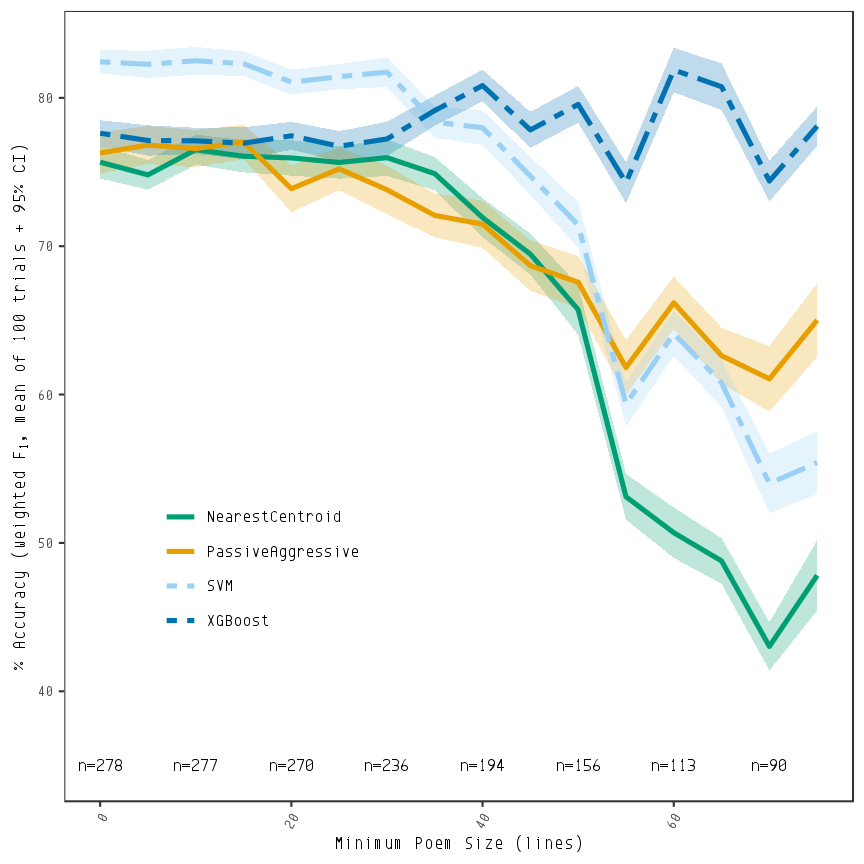

In [53]:
%%R -i bywork,n_df -h 6 -w 6 -u in -r 144

library(ggplot2)
library(extrafont)

cbbPaletteDark <- c("#009E73", "#e79f00", "#9ad0f3", "#0072B2", "#D55E00", 
    "#CC79A7", "#F0E442")

ggplot(data=bywork, aes(x=Cutoff, y=Score*100)) +
geom_label(
    data=n_df,
    label.size=NA,
    aes(x=Cutoff, y=35, label=sprintf("n=%d",N)),
    family="Envy Code R",
    size=3
) +
geom_ribbon(
    aes(ymin=CILow*100, ymax=CIHigh*100, fill=Classifier), 
    alpha=0.25, show.legend=FALSE) +
geom_line(aes(color=Classifier,linetype=Classifier), size=1.2) +
guides(color = guide_legend(ncol=2)) +
labs(x="Minimum Poem Size (lines)",y=expression(paste("% Accuracy (weighted ",F[1],", mean of 100 trials + 95% CI)"))) +
theme_bw() +

theme(
    text = element_text(size=9, family="Envy Code R"),
    panel.grid.major=element_blank(),
    panel.grid.minor=element_blank(),
    legend.title=element_blank(),
    legend.position= c(0.25, 0.3),
    legend.text=element_text(size=8),
    axis.text.x = element_text(angle = 60, hjust = 1, vjust=1)
) +
scale_linetype_manual(values=c("solid", "solid", "twodash", "twodash")) +
scale_color_manual(values=cbbPaletteDark) +
scale_fill_manual(values=cbbPaletteDark)

# fn <- "../paper/figures/ngram_acc_work.pdf"
# ggsave(fn, dpi=600, width=6, height=6, device=cairo_pdf)


In [20]:
%%capture

dfs = []
for n in range(0,80,5):
    dfs.append(test_clfs(GRAPH_CLASSIFIERS, corpus, 'Author', cutoff=n, samps=100))
byauth = pd.concat(dfs)

In [21]:
byauth

,Classifier,Score,Cutoff,CILow,CIHigh
0,PassiveAggressive,0.921542,0,0.915982,0.927102
1,XGBoost,0.942874,0,0.938125,0.947623
2,SVM,0.896817,0,0.891303,0.902331
3,NearestCentroid,0.876125,0,0.867212,0.885038
0,PassiveAggressive,0.923389,5,0.917430,0.929348
...,...,...,...,...,...
3,NearestCentroid,0.715194,70,0.706053,0.724335
0,PassiveAggressive,0.735728,75,0.724235,0.747221
1,XGBoost,0.848529,75,0.835909,0.861150
2,SVM,0.681978,75,0.670820,0.693136


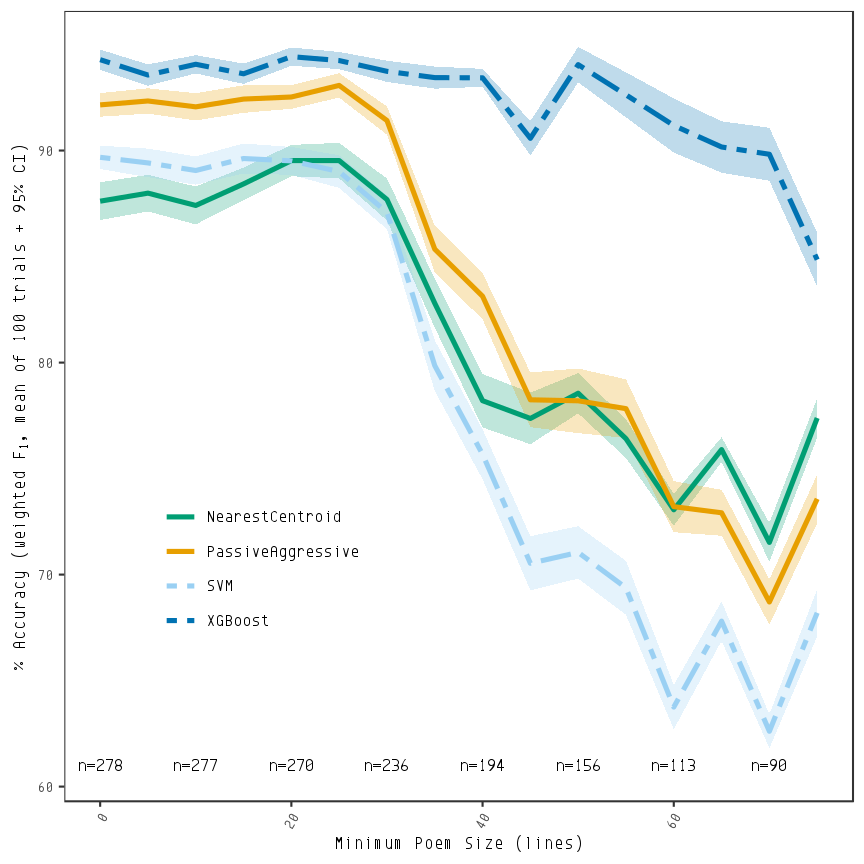

In [52]:
%%R -i byauth,n_df -h 6 -w 6 -u in -r 144

cbbPaletteDark <- c("#009E73", "#e79f00", "#9ad0f3", "#0072B2", "#D55E00", 
    "#CC79A7", "#F0E442")

ggplot(data=byauth, aes(x=Cutoff, y=Score*100)) +
geom_label(
    data=n_df,
    label.size=NA,
    aes(x=Cutoff, y=61, label=sprintf("n=%d",N)),
    family="Envy Code R",
    size=3
) +
geom_ribbon(
    aes(ymin=CILow*100, ymax=CIHigh*100, fill=Classifier), 
    alpha=0.25, show.legend=FALSE) +
geom_line(aes(color=Classifier,linetype=Classifier), size=1.2) +

labs(x="Minimum Poem Size (lines)",y=expression(paste("% Accuracy (weighted ",F[1],", mean of 100 trials + 95% CI)"))) +
theme_bw() +
guides(color = guide_legend(ncol=2)) +

theme(
    text = element_text(size=9, family="Envy Code R"),
    panel.grid.major=element_blank(),
    panel.grid.minor=element_blank(),
    legend.title=element_blank(),
    legend.position= c(0.25, 0.3),
    legend.text=element_text(size=8),
    axis.text.x = element_text(angle = 60, hjust = 1, vjust=1)
) +

scale_linetype_manual(values=c("solid", "solid", "twodash", "twodash")) +
scale_color_manual(values=cbbPaletteDark) +
scale_fill_manual(values=cbbPaletteDark)

# fn <- "../paper/figures/ngram_acc_auth.pdf"
# ggsave(fn, dpi=600, width=6, height=6, device=cairo_pdf)


# Confusion Matrix

Finally, it is often useful to draw a confusion matrix to see which labels are the most distinctive. Here I examine just the accuracy per work. The matrix itself is the mean of 100 `StratifiedShuffleSplit` trials with a 20% holdout.

In [23]:
conf_matrix_list_of_arrays = []
X,y = corpus.drop(['Author','Work','Poem','LEN'],axis=1), corpus.Work
names = sorted(y.unique())
sss = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
clf = svml()

for train_index, test_index in sss.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    conf_matrix = confusion_matrix(y_test, clf.predict(X_test))
    conf_matrix_list_of_arrays.append(conf_matrix)

In [24]:
conf_mat = np.mean(conf_matrix_list_of_arrays, axis=0)

In [25]:
# build the df for ggplot
cm_pct = [x/x.sum()*100 for x in conf_mat]
m = []
names = sorted(vecs['Work'].unique())
for y,arr in enumerate(cm_pct):
    for x,val in enumerate(arr):
        m.append({'x':names[x], 'y':names[y], 'val':val})
cmdf = pd.DataFrame(m)
cmdf.head()

,x,y,val
0,Am.,Am.,87.4
1,Cat.,Am.,0.0
2,Ep.,Am.,2.0
3,Pont.,Am.,0.0
4,Prop.,Am.,10.5


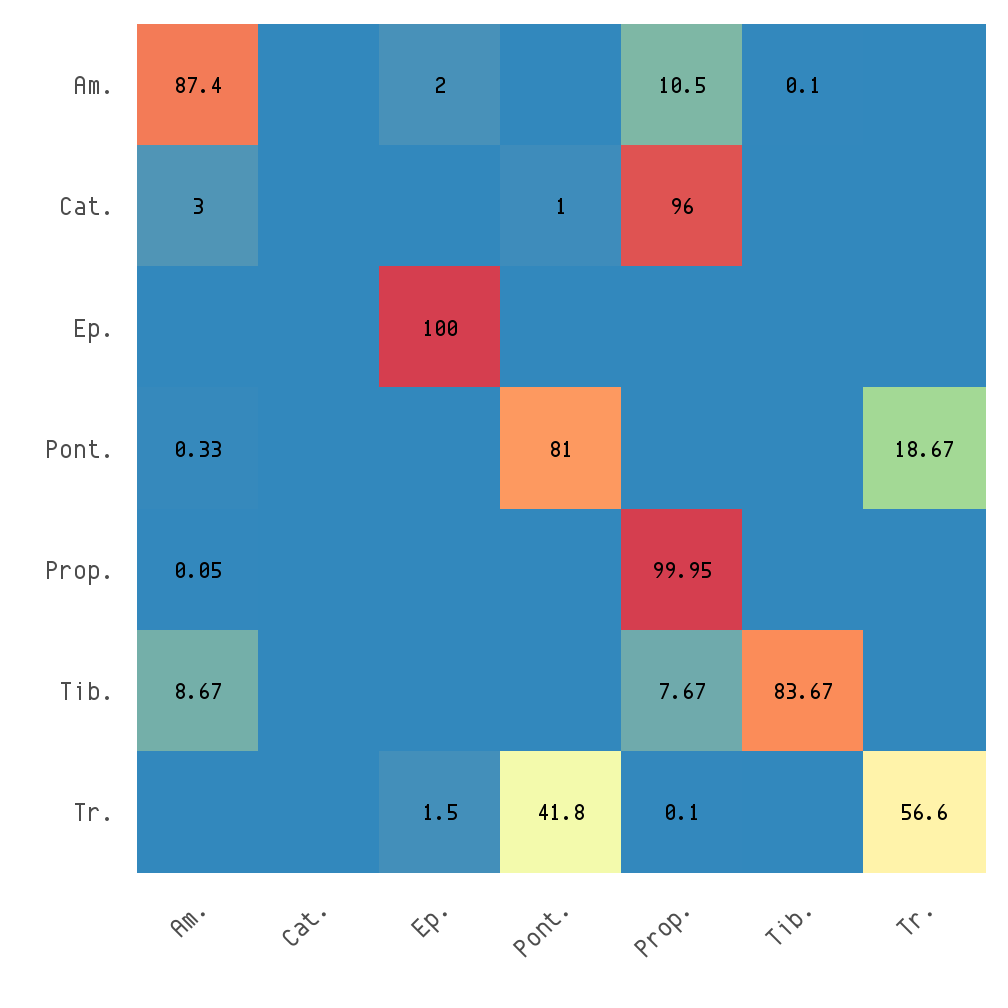

In [51]:
%%R -i cmdf -h 7 -w 7 -u in -r 144

library(tidyverse)
library(extrafont)

cmdf <- cmdf %>%
  mutate(x = factor(x, levels= unique(x)), # alphabetical order by default
         y = factor(y, levels = rev(unique(y)))) # force reverse alphabetical order
    
ggplot(cmdf, aes(x=x, y=y, fill=val)) +
# slightly overlap the tiles to avoid a visible border line
geom_tile(width=1.01, height=1.01) +
scale_fill_distiller(palette="Spectral", direction=-1) +
guides(fill=F) + # removing legend for `fill`
theme_minimal() +
# force it to be square
coord_equal() +
# supress output for 0
geom_text(
    aes(label=ifelse(round(cmdf$val,digits=2)==0, "", round(val,digits=2))),
    color="black",
    size=4,
    family="Envy Code R") + 

theme(
    text = element_text(size=16, family="Envy Code R"),
    panel.grid.minor=element_blank(),
    panel.grid.major=element_blank(),
    panel.border=element_blank(),
    legend.title=element_blank(),
    axis.text.x = element_text(angle = 45, hjust = 1, vjust=0.95),
    plot.title = element_text(hjust = 0.5),
    plot.subtitle = element_text(hjust = 0.5)
) +
labs(x="", y="")

# fn <- "../paper/figures/cm_ngrams.pdf"
# ggsave(fn, dpi=600, width=7, height=7, device=cairo_pdf)
